In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            loaded_list = [float(line.strip()) for line in file]
        print(f"List loaded from {filename}")
        return loaded_list
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return None
    except ValueError as e:
        print(f"Error converting value to float: {e}")
        return None

In [5]:
def BoseHubbard_ham(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators()
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        "I2": np.eye(2)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(2))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)


def prodect_state(ttn, bond_dim=2):
    zero_state = deepcopy(ttn)
    zero = np.asarray([1/np.sqrt(2), 1/np.sqrt(2)])
    for node_id in zero_state.nodes.keys():
        n = zero_state.tensors[node_id].ndim - 1
        tensor = zero.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        zero_state.tensors[node_id] = T
        zero_state.nodes[node_id].link_tensor(T)  
    return zero_state

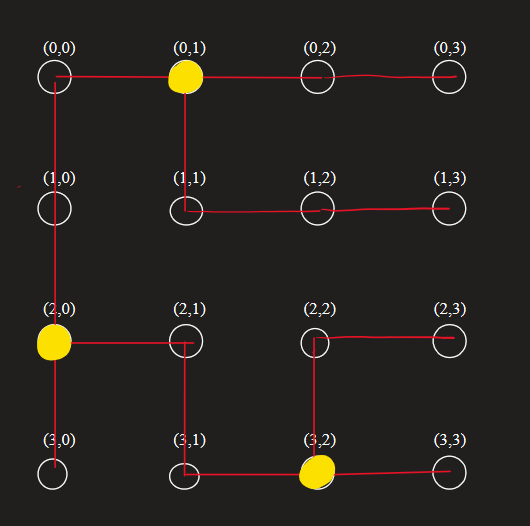

In [6]:
shapes = {
    (0, 0): (2, 2, 2),
    (0, 1): (2, 2, 2, 2),
    (0, 2): (2, 2, 2),
    (0, 3): (2, 2),
    (1, 0): (2, 2, 2),
    (1, 1): (2, 2, 2),
    (1, 2): (2, 2, 2),
    (1, 3): (2, 2),
    (2, 0): (2, 2, 2, 2),
    (2, 1): (2, 2, 2),
    (2, 2): (2, 2, 2),
    (2, 3): (2, 2),
    (3, 0): (2, 2),
    (3, 1): (2, 2, 2),
    (3, 2): (2, 2, 2, 2),
    (3, 3): (2, 2)
}

nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((1, 1), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)


ttn1 = prodect_state(ttn , bond_dim= 2)
# ttn1.normalize_ttn()

H1 = BoseHubbard_ham(0.4, 0.5, 4, 4)
H1 = H1.pad_with_identities(ttn1 , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn1)


X , Y , Z = ptn.pauli_matrices()
tp = ptn.TensorProduct({'Site(0,0)': X, 
                        "Site(0,1)" :Y ,
                        "Site(0,2)" : Z,
                        "Site(0,3)" : X,
                        "Site(1,0)" : Y,
                        "Site(1,1)" : Z,
                        "Site(1,2)" : X,
                        "Site(1,3)" : Y,
                        "Site(2,0)" : Z,
                        "Site(2,1)" : X,
                        "Site(2,2)" : Y,
                        "Site(2,3)" : Z,
                        "Site(3,0)" : X,
                        "Site(3,1)" : Y,
                        "Site(3,2)" : Z,
                        "Site(3,3)" : X})


In [7]:
tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn1,
                                     hamiltonian = ttno,
                                     time_step_size = 0.01,
                                     final_time = 2,
                                     operators = tp,
                                     num_vecs = 3,
                                     tau = 1e-2,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-3 , total_tol = -np.inf),
                                     expansion_steps = 10,
                                     initial_tol= 1e-22,
                                     tol_step= 1,
                                     max_bond= 55,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = None)

In [8]:
tdvp_ex1.run_ex(evaluation_time=2)

times = tdvp_ex1.times()
tdvp_results_ex1 = tdvp_ex1.operator_results(realise=True)[0]

  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [48:32<00:00, 14.49s/it]


In [9]:
save_list (tdvp_results_ex1, "3_prime_3")


List saved to results/3_prime_3


In [10]:
for id in tdvp_ex1.state.tensors:
    print(id , tdvp_ex1.state.tensors[id].shape)

Site(1,3) (2, 2)
Site(1,2) (4, 2, 2)
Site(1,1) (8, 4, 2)
Site(0,3) (2, 2)
Site(0,2) (4, 2, 2)
Site(0,1) (40, 8, 4, 2)
Site(0,0) (38, 40, 2)
Site(1,0) (38, 61, 2)
Site(3,0) (2, 2)
Site(2,0) (61, 25, 2, 2)
Site(2,1) (25, 23, 2)
Site(3,1) (23, 16, 2)
Site(3,3) (2, 2)
Site(3,2) (16, 4, 2, 2)
Site(2,2) (4, 2, 2)
Site(2,3) (2, 2)


In [4]:
times =np.array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

List loaded from results/3_prime_1
List loaded from results/3_prime_2
List loaded from results/3_prime_3
List loaded from results/5_2


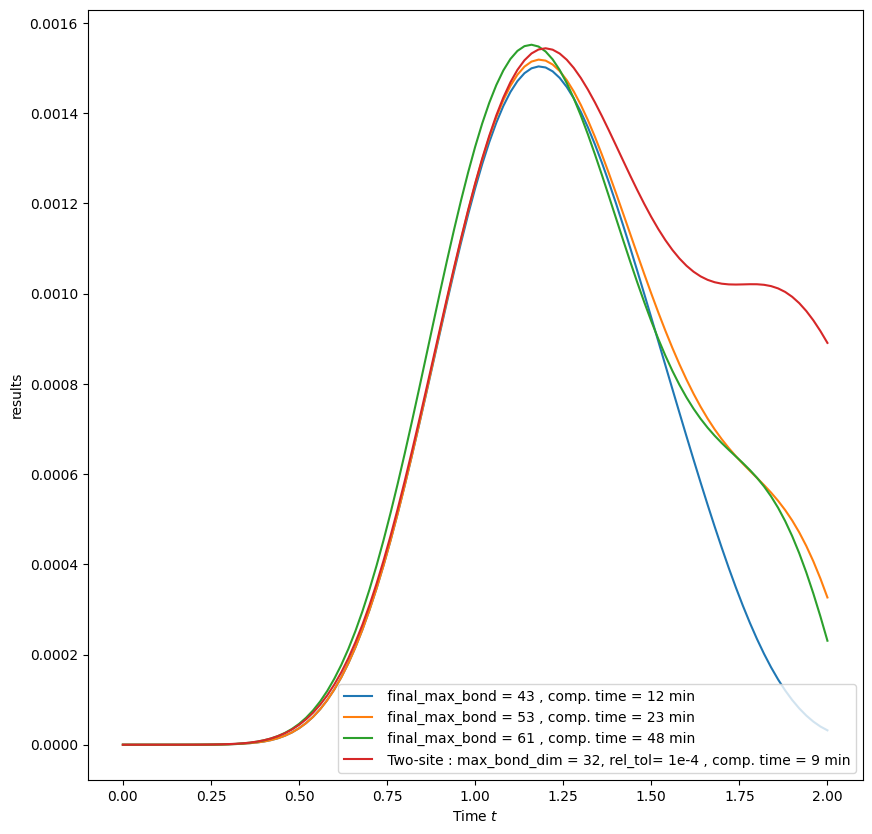

In [5]:
fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))


axs1.plot(times,  load_list("3_prime_1") , label=' final_max_bond = 43 , comp. time = 12 min')
axs1.plot(times,  load_list("3_prime_2") , label=' final_max_bond = 53 , comp. time = 23 min')
axs1.plot(times,  load_list("3_prime_3") , label=' final_max_bond = 61 , comp. time = 48 min')
#axs1.plot(times,  load_list("5_3") , label=' Two-site : max_bond_dim = 32, rel_tol= 1e-5 , comp. time = 78 min')
#axs1.plot(times,  load_list("5_4") , label=' Two-site : max_bond_dim = 32, rel_tol= 1e-4 , comp. time = 9 min')


axs1.set_xlabel("Time $t$")
axs1.set_ylabel("results")  
axs1.legend()

In [12]:
tdvp_twosite = ptn.SecondOrderTwoSiteTDVP(initial_state = ttn1,
                                    hamiltonian = ttno,
                                    time_step_size = 0.01,
                                    final_time = 2,
                                    operators = tp,
                                    truncation_parameters= ptn.SVDParameters(max_bond_dim= 32, rel_tol= 1e-5, total_tol= -np.inf),
                                    config = None)

In [13]:
tdvp_twosite.run(evaluation_time=2)

times = tdvp_twosite.times()
tdvp_twosite_results2 = tdvp_twosite.operator_results(realise= True)[0]

 47%|████▋     | 94/201 [09:58<11:21,  6.37s/it]


KeyboardInterrupt: 

In [ ]:
save_list (tdvp_twosite_results2 , "3_3")

List saved to results/3_2


In [ ]:
for id in tdvp_twosite.state.tensors:
    print(id , tdvp_twosite.state.tensors[id].shape)

Site(1,3) (2, 2)
Site(1,2) (4, 2, 2)
Site(0,3) (2, 2)
Site(0,2) (16, 4, 2, 2)
Site(1,1) (2, 2)
Site(0,1) (18, 16, 2, 2)
Site(0,0) (17, 18, 2)
Site(1,0) (17, 16, 2)
Site(3,0) (2, 2)
Site(2,0) (16, 16, 2, 2)
Site(2,1) (16, 16, 2)
Site(3,1) (16, 15, 2)
Site(3,3) (2, 2)
Site(3,2) (15, 4, 2, 2)
Site(2,2) (4, 2, 2)
Site(2,3) (2, 2)


In [ ]:
ttn_ex = ptn.expand_subspace(tdvp_ex1.state, ttno, 3 ,
                                1e-2, ptn.SVDParameters(max_bond_dim= np.inf, rel_tol= -np.inf , total_tol= -np.inf) ,
                                tol = 1e-20, 
                                mode = ptn.KrylovBasisMode.apply_1st_order_expansion)
ttn_ex.canonical_form("Site(0,3)", ptn.SplitMode.KEEP)
ttn_ex.normalize_ttn()

for id in ttn_ex.tensors:
    print(id , ttn_ex.tensors[id].shape)

tdvp_ex1.state = ttn_ex
tdvp_ex1._orthogonalize_init()
tdvp_ex1._init_partial_tree_cache()    

tdvp_ex1.run(evaluation_time=2)
tdvp_results_ex1 = np.append( tdvp_results_ex1, tdvp_ex1.operator_results(realise=True)[0])